# Figure 14 (appendix and animation)

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [2]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [3]:
# Scientific and datavis stack
import iris
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
# My packages
from aeolus.calc import deriv, spatial_mean, time_mean, zonal_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import get_cube_rel_days, isel
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import subplot_label_generator, tex2cf_units
from aeolus.subset import DimConstr
from pouch.clim_diag import calc_derived_cubes, longitude_of_wave_crest
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
    use_style,
)

In [5]:
# Local modules
import mypaths
from commons import DAYSIDE, GLM_SUITE_ID, SIM_LABELS

Apply custom matplotlib style sheet.

In [6]:
use_style()

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

## Load the data for the two key experiments

Define paths to input data and results.

In [7]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [8]:
%%time

runs = {}
runs_p = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="z",
    )
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

CPU times: user 4.83 s, sys: 538 ms, total: 5.37 s
Wall time: 5.53 s


---

In [9]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})

In [10]:
%%time

RESULTS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS[sim_label] = {}
    the_run = runs[sim_label]
    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run_p.coord.x.points
    RESULTS[sim_label]["lats"] = the_run_p.coord.y.points
    ghgt_p = runs_p[sim_label].ghgt.extract(p_lev_constr1)
    RESULTS[sim_label]["ghgt_p_zdev"] = ghgt_p - zonal_mean(ghgt_p)
    RESULTS[sim_label]["wave_crest_lon"] = longitude_of_wave_crest(ghgt_p)
    RESULTS[sim_label]["wave_crest_lon"].add_aux_coord(
        ghgt_p.coord(um.fcst_prd), data_dims=(0,)
    )
    RESULTS[sim_label]["days"] = get_cube_rel_days(ghgt_p)

    RESULTS[sim_label]["sigma_p"] = spatial_mean(the_run.sigma_p)
    RESULTS[sim_label]["sigma_plev"] = (
        P_LEV1 * 1e2 / the_run.const.reference_surface_pressure.data
    )
    RESULTS[sim_label]["p"] = spatial_mean(the_run.pres)
    RESULTS[sim_label]["u_cross"] = zonal_mean(the_run.u)
    RESULTS[sim_label]["temp_cross"] = zonal_mean(the_run.temp)

CPU times: user 2.66 s, sys: 1.78 s, total: 4.44 s
Wall time: 3.87 s


## Make a static image for the appendix (Figure 14)

Define periods for time averaging.

In [11]:
periods = {
    "first": {"days": [0, 20], "lim_vprof": [-40, 40], "lim_yprof": [-5, 15]},
    "second": {"days": [20, 80], "lim_vprof": [-40, 40], "lim_yprof": [-17, 17]},
    "third": {"days": [80, 200], "lim_vprof": [-150, 150], "lim_yprof": [-50, 50]},
    "fourth": {"days": [250, 450], "lim_vprof": [-150, 150], "lim_yprof": [-50, 50]},
}

Assemble the figure.

In [12]:
imgname = f"supfig1__300hpa_height_anom__eastward_wind_temperature_zonal_mean_0-500d"

ncols = len(SIM_LABELS)
nrows = 2
fig_nrows = len(periods) // 2
fig_ncols = len(periods) // fig_nrows

fig = plt.figure(constrained_layout=True, figsize=(ncols * 10, nrows * 8))
sub_figs = fig.subfigures(nrows=fig_nrows, ncols=fig_ncols, wspace=0.05, hspace=0.05)

iletters = subplot_label_generator()
for (period_key, period_prop), sub_fig in zip(periods.items(), sub_figs.flat):
    axs = sub_fig.subplots(
        ncols=ncols, nrows=nrows, gridspec_kw=dict(wspace=0.001, hspace=0.001)
    )
    day_start, day_end = period_prop["days"]
    day_constr = iris.Constraint(
        **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
    )
    sub_fig.suptitle(f"{day_start}-{day_end} day mean", size="xx-large")
    for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
        ax = axcol[0]
        ax.add_artist(AnchoredText("Geopotential\nheight anomaly", loc="upper right"))
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
        ax.set_ylim(-90, 90)
        ax.set_yticks(YLOCS)
        ax.set_xlim(-180, 180)
        ax.set_xticks(XLOCS)
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")
        ax.grid()

        # if ax.get_subplotspec().is_last_col() and ax.get_subplotspec().is_first_row():
        #     ax.set_title(
        #         f"{day_start}-{day_end} day mean",
        #         loc="right",
        #         size="large",
        #         weight="bold",
        #     )

        cube = time_mean(RESULTS[sim_label]["ghgt_p_zdev"].extract(day_constr))
        _p1 = ax.contourf(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            cube.data,
            cmap=cm.roma_r,
            levels=linspace_pm1(16) * 4e3,
            extend="both",
        )
        ax.contour(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            cube.data,
            levels=linspace_pm1(16) * 2e3,
            colors="tab:grey",
            linewidths=0.5,
        )
        ax.plot(
            [
                time_mean(
                    RESULTS[sim_label]["wave_crest_lon"].extract(day_constr)
                ).data,
                time_mean(
                    RESULTS[sim_label]["wave_crest_lon"].extract(day_constr)
                ).data,
            ],
            [-90, 90],
            color="tab:cyan",
            linewidth=2,
        )

        ax = axcol[1]
        ax.add_artist(
            AnchoredText(
                "Zonal mean zonal wind\nand air temperature", loc="upper right"
            )
        )
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        # ax.set_ylim(1000, 2e-3)
        ax.set_ylim(1, 0)
        # ax.set_yscale("log")
        ax.set_xlim(-90, 90)
        ax.set_xticks(YLOCS)
        ax.set_xlabel("Latitude [$\degree$]", fontsize="small")
        # ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
        ax.set_ylabel("$\sigma=p/p_s$", fontsize="small")

        _sigma_p = time_mean(RESULTS[sim_label]["sigma_p"].extract(day_constr))
        cube = time_mean(RESULTS[sim_label]["u_cross"].extract(day_constr))
        ax.axhline(
            y=P_LEV1,
            color="tab:cyan",
            linewidth=2,
        )
        ax.axvline(**KW_ZERO_LINE)
        _p2 = ax.contourf(
            RESULTS[sim_label]["lats"],
            # p.data * 1e-2,
            _sigma_p.data,
            cube.data,
            levels=linspace_pm1(10) * 50,
            cmap=cm.vik,
            extend="both",
        )
        cube = time_mean(RESULTS[sim_label]["temp_cross"].extract(day_constr))
        _p3 = ax.contour(
            RESULTS[sim_label]["lats"],
            # p.data * 1e-2,
            _sigma_p.data,
            cube.data,
            levels=np.arange(100, 1000, 5),
            cmap=cm.batlow,
            norm=mpl.colors.Normalize(vmin=210, vmax=340),
            extend="both",
        )
        # ax.clabel(_p3, fmt="%.0f")  # MPL bug?
plt.close()

# Show the figure

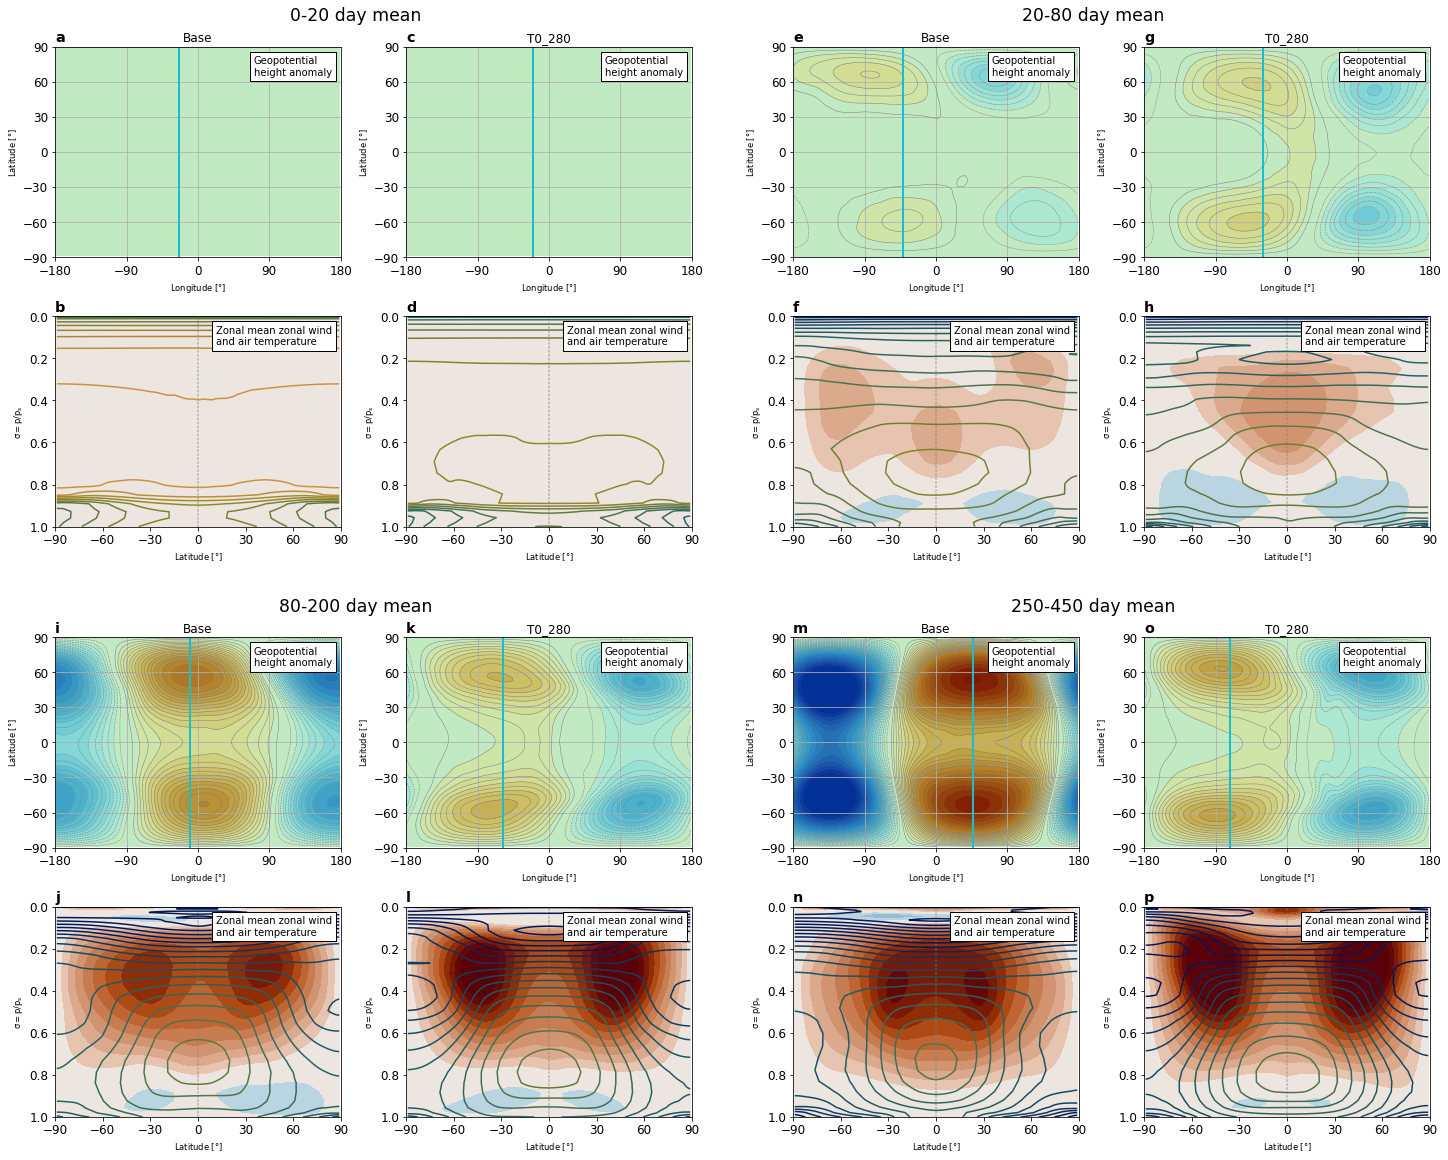

In [13]:
fig

* **This figure corresponds to the animation provided as Supplemental Video 1 (see below) and shows the stationary wave pattern and zonal mean atmospheric structure during the four time periods discussed in Sec. 3.2.**
* **Fig. 1c,d and 7c,d show the corresponding variables in steady state.**
* **Panels (a, c, e, g, i, k, m, o) show the eddy geopotential height defined as the deviation from the zonal mean of the height of the $300\,hPa$ isobaric surface (shading, $m$).**
* **The cyan lines show the mean longitude of the planetary wave crest, defined as the maximum of the geopotential height anomaly.**
* **Panels (b, d, f, h, j, l, n, p) show the vertical cross-section of the zonal mean eastward wind (shading, $m\,s^{-1}$) and air temperature (contours, $K$).**
* **All variables are averaged over the periods of (a, b, c, d) 0-20 days, (e, f, g, h) 20-80 days, (i, j, k, l) 80-200 days, and (m, n, o, p) 250-450 days.**

In [14]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_spinup/supfig1__300hpa_height_anom__eastward_wind_temperature_zonal_mean_0-500d.png


## Animation

In [ ]:
%%time

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__ghgt_anom_{P_LEV1}hpa"

ncols = len(SIM_LABELS)
nrows = 2
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(ncols * 7.5, nrows * 5),
)


def _make_frame(it):
    iletters = subplot_label_generator()
    for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):

        _sigma_p = isel(RESULTS[sim_label]["sigma_p"], um.t, it)
        # p = isel(RESULTS[sim_label]["p"], um.t, it)

        ax = axcol[0]
        ax.clear()
        ax.set_title("Geopotential height anomaly", **KW_AUX_TTL)
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
        ax.set_ylim(-90, 90)
        ax.set_yticks(YLOCS)
        ax.set_xlim(-180, 180)
        ax.set_xticks(XLOCS)
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")
        ax.grid()
        # cube = next(ghgt_zdev_time_slices)
        if ax.get_subplotspec().is_last_col() and ax.get_subplotspec().is_first_row():
            ax.set_title(
                f"Day:{int(RESULTS[sim_label]['days'][it])+1:>4d}", loc="right"
            )
        cube = isel(RESULTS[sim_label]["ghgt_p_zdev"], um.t, it)
        _p1 = ax.contourf(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            cube.data,
            cmap=cm.roma_r,
            levels=linspace_pm1(16) * 4e3,
            extend="both",
        )
        ax.contour(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            cube.data,
            levels=linspace_pm1(16) * 2e3,
            colors="tab:grey",
            linewidths=0.5,
        )
        ax.plot(
            [
                RESULTS[sim_label]["wave_crest_lon"].data[it],
                RESULTS[sim_label]["wave_crest_lon"].data[it],
            ],
            [-90, 90],
            color="tab:cyan",
            linewidth=2,
        )

        ax = axcol[1]
        ax.clear()
        ax.set_title("Zonal mean zonal wind\nand air temperature", **KW_AUX_TTL)
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        # ax.set_ylim(1000, 2e-3)
        ax.set_ylim(1, 0)
        # ax.set_yscale("log")
        ax.set_xlim(-90, 90)
        ax.set_xticks(YLOCS)
        ax.set_xlabel("Latitude [$\degree$]", fontsize="small")
        # ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
        ax.set_ylabel("Pressure [$hPa$]", fontsize="small")

        cube = isel(RESULTS[sim_label]["u_cross"], um.t, it)
        ax.axhline(
            y=P_LEV1,
            color="tab:cyan",
            linewidth=2,
        )
        ax.axvline(**KW_ZERO_LINE)
        _p2 = ax.contourf(
            RESULTS[sim_label]["lats"],
            # p.data * 1e-2,
            _sigma_p.data,
            cube.data,
            levels=linspace_pm1(10) * 50,
            cmap=cm.vik,
            extend="both",
        )
        cube = isel(RESULTS[sim_label]["temp_cross"], um.t, it)
        _p3 = ax.contour(
            RESULTS[sim_label]["lats"],
            # p.data * 1e-2,
            _sigma_p.data,
            cube.data,
            levels=np.arange(100, 1000, 5),
            cmap=cm.batlow,
            norm=mpl.colors.Normalize(vmin=210, vmax=340),
            extend="both",
        )
        ax.clabel(_p3, fmt="%.0f")
    fig.tight_layout()


_make_frame(0)
frames = 500
anim = mpl.animation.FuncAnimation(
    fig, _make_frame, frames=frames, interval=100, blit=False
)
anim.save(plotdir / f"{imgname}_0-{frames:03d}d.mp4")

plt.close()

---

## Extra

### Animations of the vertical cross-sections of heating rates

In [ ]:
cmap_heating = cm.broc.copy()
cmap_heating.set_under("tab:purple")
cmap_heating.set_over("tab:orange")

In [ ]:
VCROSS_VRBL = {
    "dt_diab": {
        "recipe": lambda cl: sum(
            cl.extract_cubes([um.dt_sw, um.dt_lw, um.dt_bl, um.dt_lsppn, um.dt_cv])
        ),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "SW+LW+BL+LSPPN+CV heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lh": {
        "recipe": lambda cl: sum(cl.extract_cubes([um.dt_bl, um.dt_lsppn, um.dt_cv])),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "BL+LSPPN+CV heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_bl": {
        "recipe": lambda cl: cl.extract_cube(um.dt_bl),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "BL heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lsppn": {
        "recipe": lambda cl: cl.extract_cube(um.dt_lsppn),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "LSPPN heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_cv": {
        "recipe": lambda cl: cl.extract_cube(um.dt_cv),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "CV heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_rad": {
        "recipe": lambda cl: sum(cl.extract_cubes([um.dt_sw, um.dt_lw])),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "SW+LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_rad_cs": {
        "recipe": lambda cl: sum(cl.extract_cubes([um.dt_sw_cs, um.dt_lw_cs])),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "SW+LW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw": {
        "recipe": lambda cl: cl.extract_cube(um.dt_sw),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "SW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw_cs": {
        "recipe": lambda cl: cl.extract_cube(um.dt_sw_cs),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "SW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw": {
        "recipe": lambda cl: cl.extract_cube(um.dt_lw),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw_cs": {
        "recipe": lambda cl: cl.extract_cube(um.dt_lw_cs),
        "method": "contourf",
        "kw_plt": {
            "cmap": cmap_heating,
            "levels": linspace_pm1(10) * 10,
        },
        "title": "LW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
}

In [ ]:
vrbls_to_show = ["dt_diab", "dt_rad", "dt_lh", "dt_cv"]

In [ ]:
# reduce = lambda cube: cube.extract(ss_lon)
reduce = lambda cube: zonal_mean(cube.extract(DAYSIDE.constraint))
suffix = "dayside_zm"

RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}
    the_run = runs[sim_label]
    RESULTS[sim_label]["y"] = the_run.coord.z.points * 1e-3
    RESULTS[sim_label]["x"] = the_run.coord.y.points
    RESULTS[sim_label]["days"] = get_cube_rel_days(
        the_run._cubes.extract(DimConstr().relax.t)[0]
    )
    for vrbl_key in vrbls_to_show:  # VCROSS_VRBL.items():
        vrbl_prop = VCROSS_VRBL[vrbl_key]
        RESULTS[sim_label][vrbl_key] = reduce(vrbl_prop["recipe"](the_run._cubes))
        RESULTS[sim_label][vrbl_key].convert_units(tex2cf_units(vrbl_prop["tex_units"]))

In [ ]:
%%time

add_min_max = True
kw_common = dict(extend="both")

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__{'_'.join(vrbls_to_show)}__{suffix}"

ncols = len(SIM_LABELS)
nrows = len(vrbls_to_show)

mosaic = [
    [
        i
        for j in [
            [f"{vrbl_key}-{sim_label}", f"{vrbl_key}-{sim_label}-cax"]
            for sim_label in SIM_LABELS.keys()
        ]
        for i in j
    ]
    for vrbl_key in vrbls_to_show
]

fig = plt.figure(constrained_layout=True, figsize=(ncols * 8, nrows * 3))


def _make_frame(it):
    fig.clear()
    axd = fig.subplot_mosaic(
        mosaic,
        gridspec_kw={
            # set the width ratios between the columns
            "width_ratios": [30, 1]
            * ncols,
        },
    )
    iletters = subplot_label_generator()
    for key, ax in axd.items():
        ax.clear()
        if not key.endswith("-cax"):
            ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
            ax.set_ylim(0, 20)
            ax.set_xlim(-90, 90)
            ax.set_xticks(YLOCS)
            ax.set_xticklabels(YLOCS, fontsize="xx-small")
            # ax.set_xlim(-180, 180)
            # ax.set_xticks(XLOCS)
            # ax.set_xticklabels(XLOCS, fontsize="xx-small")
            ax.grid()
    for (sim_label, sim_prop) in SIM_LABELS.items():

        for vrbl_key in vrbls_to_show:
            vrbl_prop = VCROSS_VRBL[vrbl_key]
            ax = axd[f"{vrbl_key}-{sim_label}"]
            cax = axd[f"{vrbl_key}-{sim_label}-cax"]
            if ax.get_subplotspec().is_first_row():
                ax.set_title(sim_prop["title"], **KW_MAIN_TTL)
            ax.set_title(
                f'{vrbl_prop["title"]} [{vrbl_prop["tex_units"]}]', **KW_AUX_TTL
            )
            x = RESULTS[sim_label]["x"]
            y = RESULTS[sim_label]["y"]
            days = RESULTS[sim_label]["days"]
            cube = isel(RESULTS[sim_label][vrbl_key], um.t, it)
            # cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
            _p0 = getattr(ax, vrbl_prop["method"])(
                x, y, cube.data, **vrbl_prop["kw_plt"], **kw_common
            )
            cbar = fig.colorbar(_p0, cax=cax, pad=0.02)
            if add_min_max:
                fmt = vrbl_prop.get("fmt", "3.1e")
                cube_min = cube.data.min()
                cube_max = cube.data.max()
                at = AnchoredText(
                    f"Min: {cube_min:>{fmt}}\nMax: {cube_max:>{fmt}}",
                    prop=dict(color="k", size="x-small"),
                    frameon=True,
                    loc="lower right",
                )
                at.patch.set_facecolor(mpl.colors.to_rgba(bg_color, alpha=0.75))
                ax.add_artist(at)
    for ax in axd.values():
        if ax.get_subplotspec().is_last_col() and ax.get_subplotspec().is_first_row():
            ax.set_title(f"Day:{int(days[it])+1:>4d}\n", loc="right")


_make_frame(0)
frames = 200
anim = mpl.animation.FuncAnimation(
    fig, _make_frame, frames=frames, interval=100, blit=False
)
anim.save(plotdir / f"{imgname}_0-{frames:03d}d.mp4")

plt.close()